In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from collections import Counter
import h5py

from omegaconf import OmegaConf

In [2]:
# Load config
preproc_conf = OmegaConf.load("../conf/preproc.yaml")
preproc_conf = preproc_conf['classic_mil_on_embeddings_bag']['tcga_brca_224_224_patches_jmcs']

In [3]:
preproc_conf.keys()

dict_keys(['wsi_extension', 'cv_split_dir', 'stage_labels_csv', 'data_root_dir', 'slide_root_dir', 'mask_dir', 'reference_image_macenko_bracs', 'patch_dir_macenko_bracs', 'patch_size', 'patch_level', 'masking_adapt', 'uni_embedder_finetuned_weights_macenko', 'uni_finetuned_emb_dir_macenko', 'uni_finetuned_biopsy_dir_macenko'])

### Load relevant data for tcga-brca

In [4]:
patient_df_column_info = list(pd.read_csv(preproc_conf.stage_labels_csv, skiprows=1, delimiter='\t', nrows=0))
patient_df_column_info

['#Identifier to uniquely specify a patient.',
 'Subtype',
 'Text field to hold cancer type acronym used by TCGA PanCanAtlas.',
 'Legacy DMP patient identifier (DMPnnnn)',
 'Age at which a condition or disease was first diagnosed.',
 'Sex',
 'The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria.',
 'The version or edition of the American Joint Committee on Cancer Cancer Staging Handbooks, a publication by the group formed for the purpose of developing a system of clinical staging for cancer that is acceptable to the American medical profession and is compatible with other accepted classifications.',
 'Time interval from the date of last followup to the date of initial pathologic diagnosis, represented as a calculated number of days..',
 "Time interval from a person's date of birth to the date of initial pathologic diagnosis, represented as a calculated number of days.",
 'Time interval from th

#### Dataframe for patients 

In [5]:
patient_df = pd.read_csv(preproc_conf.stage_labels_csv, skiprows=4, delimiter='\t')
patient_df.head(2)

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
0,TCGA-3C-AAAU,BRCA_LumA,BRCA,6E7D5EC6-A469-467C-B748-237353C23416,55,Female,STAGE X,6TH,4047.0,-20211.0,...,Yes,0:LIVING,133.050597,0:ALIVE OR DEAD TUMOR FREE,133.050597,1:Recurred/Progressed,59.440444,1:PROGRESSION,59.440444,EUR
1,TCGA-3C-AALI,BRCA_Her2,BRCA,55262FCB-1B01-4480-B322-36570430C917,50,Female,STAGE IIB,6TH,4005.0,-18538.0,...,Yes,0:LIVING,131.669790,0:ALIVE OR DEAD TUMOR FREE,131.669790,0:DiseaseFree,131.669790,0:CENSORED,131.669790,AFR


In [6]:
patient_df.tail(2)

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
1082,TCGA-Z7-A8R5,BRCA_LumA,BRCA,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,61,Female,STAGE IIIA,6TH,3287.0,-22280.0,...,Yes,0:LIVING,108.064569,0:ALIVE OR DEAD TUMOR FREE,108.064569,NaN,NaN,1:PROGRESSION,5.950620,EUR
1083,TCGA-Z7-A8R6,BRCA_LumB,BRCA,B1D44C81-747D-471F-9093-AEB262A17975,46,Female,STAGE I,6TH,3256.0,-16955.0,...,Yes,0:LIVING,107.045402,0:ALIVE OR DEAD TUMOR FREE,107.045402,0:DiseaseFree,107.045402,0:CENSORED,107.045402,EUR


### Flowchart step 0 - Initial cohort

In [7]:
patient_df.PATIENT_ID.shape

(1084,)

In [8]:
Counter(patient_df.AJCC_PATHOLOGIC_TUMOR_STAGE)

Counter({'STAGE IIA': 355,
         'STAGE IIB': 255,
         'STAGE IIIA': 155,
         'STAGE I': 89,
         'STAGE IA': 86,
         'STAGE IIIC': 64,
         'STAGE IIIB': 28,
         'STAGE IV': 19,
         'STAGE X': 14,
         'STAGE IB': 6,
         'STAGE II': 6,
         nan: 5,
         'STAGE III': 2})

In [9]:
print("Initial cohort: Number of patients: ", patient_df.PATIENT_ID.nunique())

Initial cohort: Number of patients:  1084


In [10]:
patient_df.columns

Index(['PATIENT_ID', 'SUBTYPE', 'CANCER_TYPE_ACRONYM', 'OTHER_PATIENT_ID',
       'AGE', 'SEX', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'AJCC_STAGING_EDITION',
       'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH',
       'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 'ETHNICITY',
       'FORM_COMPLETION_DATE', 'HISTORY_NEOADJUVANT_TRTYN', 'ICD_10',
       'ICD_O_3_HISTOLOGY', 'ICD_O_3_SITE', 'INFORMED_CONSENT_VERIFIED',
       'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 'PATH_M_STAGE',
       'PATH_N_STAGE', 'PATH_T_STAGE', 'PERSON_NEOPLASM_CANCER_STATUS',
       'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', 'PRIOR_DX', 'RACE',
       'RADIATION_THERAPY', 'WEIGHT', 'IN_PANCANPATHWAYS_FREEZE', 'OS_STATUS',
       'OS_MONTHS', 'DSS_STATUS', 'DSS_MONTHS', 'DFS_STATUS', 'DFS_MONTHS',
       'PFS_STATUS', 'PFS_MONTHS', 'GENETIC_ANCESTRY_LABEL'],
      dtype='object')

#### Inspect stage data

In [11]:
np.unique( patient_df.AJCC_PATHOLOGIC_TUMOR_STAGE.astype(str), return_counts=True )

(array(['STAGE I', 'STAGE IA', 'STAGE IB', 'STAGE II', 'STAGE IIA',
        'STAGE IIB', 'STAGE III', 'STAGE IIIA', 'STAGE IIIB', 'STAGE IIIC',
        'STAGE IV', 'STAGE X', 'nan'], dtype=object),
 array([ 89,  86,   6,   6, 355, 255,   2, 155,  28,  64,  19,  14,   5]))

### Flowchart step 1 - excluding stage NaN and X

In [12]:
print("Number of patients excluded: ", patient_df[patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE'].isna() | (patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE'] == 'STAGE X')].PATIENT_ID.nunique()) # 5 NaN + 19 stage X

Number of patients excluded:  19


In [13]:
print("Number of patients: ", patient_df.PATIENT_ID.nunique() - 
                              patient_df[patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE'].isna() | (patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE'] == 'STAGE X')].PATIENT_ID.nunique())

Number of patients:  1065


In [14]:
patient_df = patient_df[~patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE'].isna() & ~(patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE'] == 'STAGE X')]

### Flowchart step 2 - excluding stage IV

In [15]:
print("Number of patients excluded: ", patient_df[patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE']=="STAGE IV"].PATIENT_ID.nunique()) # 19 stage IV

Number of patients excluded:  19


In [16]:
print("Number of patients: ", patient_df.PATIENT_ID.nunique() - 
                              patient_df[patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE']=="STAGE IV"].PATIENT_ID.nunique())

Number of patients:  1046


In [17]:
patient_df = patient_df[patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE']!="STAGE IV"]

#### Map stage to int

In [18]:
# map cancer stage to 0 - 4: (leave out STAGE X, https://academic.oup.com/bioinformatics/article/34/13/i412/5045767)
# update, leave out stage IV
def stage_to_int(stage):
    #if stage == "0":
    #    return 0
    if stage == 'STAGE I' or stage == "STAGE IA" or stage == "STAGE IB":
        return 1
    elif stage == 'STAGE II' or stage == "STAGE IIA" or stage == "STAGE IIB":
        return 2
    elif stage == 'STAGE III' or stage == "STAGE IIIA" or stage == "STAGE IIIB" or stage == "STAGE IIIC":
        return 3
    #elif stage == "STAGE IV":
    #    return 4
    else:
        return np.nan

In [19]:
patient_df['stage'] = patient_df['AJCC_PATHOLOGIC_TUMOR_STAGE'].apply(stage_to_int)

In [20]:
patient_df['stage'].isna().sum()

0

### Filtering

In [21]:
patient_df = patient_df[~patient_df['stage'].isna()]
patient_df = patient_df.reset_index(drop=True)

In [22]:
Counter(patient_df[~patient_df.stage.isna()]["stage"])

Counter({2: 616, 3: 249, 1: 181})

### Filter any treatment and perform additional data cleaning

In [ ]:
data_parent = os.path.dirname(preproc_conf.stage_labels_csv) + '/'
data_parent

In [24]:
data_timeline_treatment = pd.read_csv( data_parent + 'data_timeline_treatment.txt', 
                                       delimiter='\t' )
data_timeline_treatment.head(2)

,PATIENT_ID,START_DATE,STOP_DATE,EVENT_TYPE,TREATMENT_TYPE,TREATMENT_SUBTYPE,AGENT,NUMBER_OF_CYCLES,PRESCRIBED_DOSE,PRESCRIBED_DOSE_UNITS,...,TOTAL_DOSE_UNITS,TX_ON_CLINICAL_TRIAL,ANATOMIC_TREATMENT_SITE,COURSE_NUMBER,NUMBER_OF_FRACTIONS,RADIATION_DOSAGE,RADIATION_TREATMENT_ONGOING,RADIATION_TYPE,RADIATION_TYPE_NOTES,RADIATION_UNITS
0,TCGA-3C-AAAU,1828,NaN,Treatment,Chemotherapy,NaN,Goserelin,NaN,NaN,NaN,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-3C-AALI,43,117.0,Treatment,Other,NaN,Poly E,NaN,NaN,NaN,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_timeline_treatment.shape

(2847, 27)

In [26]:
data_timeline_treatment.PATIENT_ID.nunique()

790

In [27]:
data_timeline_sample_acquisition = pd.read_csv( data_parent + 'data_timeline_sample_acquisition.txt', 
                                                delimiter='\t' )
data_timeline_sample_acquisition.head(2)

,PATIENT_ID,START_DATE,STOP_DATE,EVENT_TYPE,SAMPLE_ID,METHOD_OF_SAMPLE_PROCUREMENT,COUNTRY,SAMPLE_PRESCREENED,TOP_SLIDE_SUBMITTED,TUMOR_NECROSIS_PERCENT,TUMOR_NUCLEI_PERCENT,TUMOR_WEIGHT,VESSEL_USED
0,TCGA-3C-AAAU,0,NaN,Sample Acquisition,TCGA-3C-AAAU-01,Modified Radical Mastectomy,United States,Yes,NaN,1.0,80,150.0,Cryomold
1,TCGA-3C-AALI,13,NaN,Sample Acquisition,TCGA-3C-AALI-01,Lumpectomy,United States,Yes,NaN,5.0,60,150.0,Cryomold


In [28]:
data_timeline_sample_acquisition.shape

(1081, 13)

In [29]:
data_timeline_sample_acquisition.PATIENT_ID.nunique()

1080

In [30]:
data_timeline_sample_acquisition.rename( columns={'START_DATE': 'START_DATE_sample_acquisition', 
                                                  'STOP_DATE': 'STOP_DATE_sample_acquisition', 
                                                   'EVENT_TYPE': 'EVENT_TYPE_sample_acquisition'}, inplace=True )

data_timeline_treatment.rename( columns={'START_DATE': 'START_DATE_data_timeline_treatment', 
                                         'STOP_DATE': 'STOP_DATE_data_timeline_treatment', 
                                         'EVENT_TYPE': 'EVENT_TYPE_data_timeline_treatment'}, inplace=True )

In [31]:
sample_treatment_df = pd.merge( left=data_timeline_sample_acquisition, right=data_timeline_treatment, on='PATIENT_ID' )
sample_treatment_df.head(2)

,PATIENT_ID,START_DATE_sample_acquisition,STOP_DATE_sample_acquisition,EVENT_TYPE_sample_acquisition,SAMPLE_ID,METHOD_OF_SAMPLE_PROCUREMENT,COUNTRY,SAMPLE_PRESCREENED,TOP_SLIDE_SUBMITTED,TUMOR_NECROSIS_PERCENT,...,TOTAL_DOSE_UNITS,TX_ON_CLINICAL_TRIAL,ANATOMIC_TREATMENT_SITE,COURSE_NUMBER,NUMBER_OF_FRACTIONS,RADIATION_DOSAGE,RADIATION_TREATMENT_ONGOING,RADIATION_TYPE,RADIATION_TYPE_NOTES,RADIATION_UNITS
0,TCGA-3C-AAAU,0,NaN,Sample Acquisition,TCGA-3C-AAAU-01,Modified Radical Mastectomy,United States,Yes,NaN,1.0,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-3C-AALI,13,NaN,Sample Acquisition,TCGA-3C-AALI-01,Lumpectomy,United States,Yes,NaN,5.0,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
sample_treatment_df.shape

(2838, 39)

In [33]:
sample_treatment_df.PATIENT_ID.nunique()

787

In [34]:
patient_sample_treatment_df = pd.merge( left=patient_df, right=sample_treatment_df, on='PATIENT_ID' )
patient_sample_treatment_df.head(2)

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,TOTAL_DOSE_UNITS,TX_ON_CLINICAL_TRIAL,ANATOMIC_TREATMENT_SITE,COURSE_NUMBER,NUMBER_OF_FRACTIONS,RADIATION_DOSAGE,RADIATION_TREATMENT_ONGOING,RADIATION_TYPE,RADIATION_TYPE_NOTES,RADIATION_UNITS
0,TCGA-3C-AALI,BRCA_Her2,BRCA,55262FCB-1B01-4480-B322-36570430C917,50,Female,STAGE IIB,6TH,4005.0,-18538.0,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-3C-AALI,BRCA_Her2,BRCA,55262FCB-1B01-4480-B322-36570430C917,50,Female,STAGE IIB,6TH,4005.0,-18538.0,...,NaN,NaN,Primary Tumor Field,NaN,25,5000,No,NaN,NaN,cgy


In [35]:
patient_sample_treatment_df.shape

(2778, 77)

In [36]:
patient_sample_treatment_df.PATIENT_ID.nunique()

768

### Flowchart step 3 - excluding cases with unknwon treatment history (not available from data_timeline_treatment.txt metadata)

In [37]:
print("Number of patients excluded: ",  patient_df.PATIENT_ID.nunique() - patient_sample_treatment_df.PATIENT_ID.nunique())  

Number of patients excluded:  278


In [38]:
print("Number of patients: ", patient_sample_treatment_df.PATIENT_ID.nunique())  

Number of patients:  768


In [39]:
data_timeline_sample_acquisition.shape, data_timeline_treatment.shape, sample_treatment_df.shape, patient_sample_treatment_df.shape

((1081, 13), (2847, 27), (2838, 39), (2778, 77))

In [40]:
Counter(patient_sample_treatment_df.METHOD_OF_SAMPLE_PROCUREMENT)

Counter({nan: 1076,
         'Modified Radical Mastectomy': 528,
         'Lumpectomy': 428,
         'Tumor Resection': 377,
         'Simple Mastectomy': 287,
         'Excisional Biopsy': 82})

### Filtering

In [41]:
patient_to_exclude_all = np.array([])

#### Flowchart step 4 - filter: any treatment before biopsy and no neoadjuvant therapy

In [42]:
filt_sample_before_any_treatment = (patient_sample_treatment_df.START_DATE_sample_acquisition < patient_sample_treatment_df.START_DATE_data_timeline_treatment) & \
                                    (patient_sample_treatment_df.HISTORY_NEOADJUVANT_TRTYN == 'No')
filt_sample_before_any_treatment.shape, filt_sample_before_any_treatment.sum()

((2778,), 2730)

In [43]:
patients_to_exclude = patient_sample_treatment_df[~filt_sample_before_any_treatment]["PATIENT_ID"].unique()
patients_to_exclude.shape

(25,)

In [44]:
patient_to_exclude_all = np.append(patient_to_exclude_all, patients_to_exclude)

In [45]:
patient_sample_treatment_df = patient_sample_treatment_df[~patient_sample_treatment_df.PATIENT_ID.isin(patients_to_exclude) ]

In [46]:
patient_sample_treatment_df["PATIENT_ID"].nunique()

743

In [47]:
768-743

25

In [48]:
print("Number of patients excluded: ",  768 - patient_sample_treatment_df["PATIENT_ID"].nunique())  

Number of patients excluded:  25


In [49]:
print("Number of patients: ", patient_sample_treatment_df["PATIENT_ID"].nunique())  

Number of patients:  743


#### Flowchart step 5 - filter: only women patiens 

In [50]:
filt_women_only = patient_sample_treatment_df.SEX == 'Female'
filt_women_only.shape, filt_women_only.sum()

((2698,), 2675)

In [51]:
patients_to_exclude = patient_sample_treatment_df[~filt_women_only]["PATIENT_ID"].unique()
patients_to_exclude.shape

(8,)

In [52]:
patient_to_exclude_all = np.append(patient_to_exclude_all, patients_to_exclude)

In [53]:
patient_sample_treatment_df = patient_sample_treatment_df[~patient_sample_treatment_df.PATIENT_ID.isin(patients_to_exclude) ]

In [54]:
patient_sample_treatment_df["PATIENT_ID"].nunique()

735

In [55]:
743-735

8

In [56]:
print("Number of patients excluded: ",  743 - patient_sample_treatment_df["PATIENT_ID"].nunique()) 

Number of patients excluded:  8


In [57]:
print("Number of patients: ", patient_sample_treatment_df["PATIENT_ID"].nunique())  

Number of patients:  735


#### Flowchart step 6 - filter: any prior diagnosis

In [58]:
filt_no_prior_dx = patient_sample_treatment_df.PRIOR_DX == 'No'
filt_no_prior_dx.shape, filt_no_prior_dx.sum()

((2675,), 2554)

In [59]:
patients_to_exclude = patient_sample_treatment_df[~filt_no_prior_dx]["PATIENT_ID"].unique()
patients_to_exclude.shape

(38,)

In [60]:
patient_to_exclude_all = np.append(patient_to_exclude_all, patients_to_exclude)

In [61]:
patient_sample_treatment_df = patient_sample_treatment_df[~patient_sample_treatment_df.PATIENT_ID.isin(patients_to_exclude) ]

In [62]:
patient_sample_treatment_df["PATIENT_ID"].nunique()

697

In [63]:
735-697

38

In [64]:
print("Number of patients excluded: ",  735 - patient_sample_treatment_df["PATIENT_ID"].nunique())  

Number of patients excluded:  38


In [65]:
print("Number of patients: ", patient_sample_treatment_df["PATIENT_ID"].nunique())  

Number of patients:  697


In [66]:
patient_sample_treatment_df.PATIENT_ID.nunique()

697

In [67]:
patient_to_exclude_all.shape

(71,)

In [68]:
np.any(np.isin(list(set(patient_to_exclude_all)), patient_sample_treatment_df.PATIENT_ID.values))

False

### Assembly of final df to be used for patients

In [69]:
slide_stage_df = pd.DataFrame([])
slide_stage_df['biopsy_id'] = patient_sample_treatment_df.PATIENT_ID
slide_stage_df['stage'] = patient_sample_treatment_df['AJCC_PATHOLOGIC_TUMOR_STAGE'].apply(stage_to_int)
slide_stage_df.head()

,biopsy_id,stage
0,TCGA-3C-AALI,2
1,TCGA-3C-AALI,2
2,TCGA-3C-AALJ,2
3,TCGA-3C-AALJ,2
4,TCGA-3C-AALJ,2


In [70]:
Counter(slide_stage_df[~slide_stage_df.stage.isna()]["stage"])

Counter({2: 1493, 3: 723, 1: 338})

In [71]:
slide_stage_df.shape

(2554, 2)

In [72]:
slide_stage_df.biopsy_id.nunique()

697

In [ ]:
with open("<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/WSI/slide_filenames.txt") as f:
    slide_id = np.array([line.strip().replace(".svs", "") for line in sorted(f)])

In [74]:
slide_id[:5]

array(['TCGA-3C-AAAU-01A-01-TS1.2F52DD63-7476-4E85-B7C6-E06092DB6CC1',
       'TCGA-3C-AALI-01A-01-TSA.7D4960A7-247F-46EE-8D4A-B55170C23EAA',
       'TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4BD-C6B76294C291',
       'TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF5-C34833B91B7C',
       'TCGA-3C-AALJ-01A-03-TSC.272FA991-8382-409A-A00A-9A3BAA6EE041'],
      dtype='<U69')

In [75]:
slide_props = np.array([ j.split('-')[5].split('.')[0][:3] for j in slide_id ])
slide_props.shape, np.unique(slide_props)

((3111,),
 array(['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6', 'BS7', 'BSA', 'BSB',
        'BSC', 'BSD', 'DX1', 'DX2', 'DX3', 'DX4', 'MS1', 'MS2', 'MSA',
        'MSB', 'MSC', 'TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6', 'TS7',
        'TSA', 'TSB', 'TSC', 'TSD', 'TSE', 'TSF', 'TSG', 'TSH', 'TSI'],
       dtype='<U3'))

In [76]:
filt = (slide_props == 'DX1') | (slide_props == 'DX2') | (slide_props == 'DX3') | (slide_props == 'DX4') # keep diagnostic slides only 
filt.sum()

1133

In [ ]:
with open("<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/WSI/slide_filenames.txt") as f:
    slide_to_biopsy = np.array(['-'.join(line.strip().replace(".svs", "").split('-')[:3]) for line in sorted(f)])

print(slide_to_biopsy.shape, slide_to_biopsy[:5])

(3111,) ['TCGA-3C-AAAU' 'TCGA-3C-AALI' 'TCGA-3C-AALI' 'TCGA-3C-AALI'
 'TCGA-3C-AALJ']


In [78]:
slide_id = slide_id[filt]
slide_to_biopsy = slide_to_biopsy[filt]

In [79]:
slide_biopsy_map = pd.DataFrame( np.vstack( (slide_id, slide_to_biopsy ) ).T, columns=['slide_id', 'biopsy_id'] )
slide_biopsy_map.shape, slide_biopsy_map[:5]

((1133, 2),
                                             slide_id     biopsy_id
 0  TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...  TCGA-3C-AALI
 1  TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...  TCGA-3C-AALI
 2  TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...  TCGA-3C-AALJ
 3  TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...  TCGA-3C-AALJ
 4  TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...  TCGA-3C-AALK)

In [80]:
slide_biopsy_map.biopsy_id.nunique()

1062

In [81]:
slide_stage_df.biopsy_id.nunique()

697

In [82]:
labels_df = slide_biopsy_map.merge( right=slide_stage_df, on='biopsy_id' ).dropna(how="any").reset_index(drop=True)
labels_df["stage"] = labels_df["stage"].astype(int)
labels_df = labels_df.drop_duplicates().reset_index(drop=True) # important to drop exact duplicate rows ! 

sort_idx = np.argsort( labels_df.slide_id.values )
labels_df = labels_df.loc[sort_idx]
labels_df.reset_index(inplace=True, drop=True)

labels_df.head()

,slide_id,biopsy_id,stage
0,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,TCGA-3C-AALI,2
1,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,TCGA-3C-AALI,2
2,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,TCGA-3C-AALJ,2
3,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...,TCGA-3C-AALJ,2
4,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,TCGA-3C-AALK,1


In [83]:
labels_df.shape

(731, 3)

In [84]:
labels_df.biopsy_id.nunique()

678

### Flowchart step 7 - excluding cases without diagnostic WSI

In [85]:
print("Number of patients excluded: ",  slide_stage_df["biopsy_id"].nunique() -
                                         labels_df["biopsy_id"].nunique())  

Number of patients excluded:  19


In [86]:
print("Number of patients: ", labels_df["biopsy_id"].nunique())  

Number of patients:  678


In [87]:
labels_df.to_csv("labels_df.csv", index=False)

### Create biopsies for patients

In [88]:
gby_temp = list(labels_df.groupby('biopsy_id',sort=False))
biopsy_idx_to_slide_idx = np.array( [ l[1].index.values for l in gby_temp ], dtype=object )

In [89]:
biopsy_idx_to_slide_idx.shape[0]

678

In [90]:
# for each biopsy make a list of the slides id's by re-shaping the df. 
biopsy_df = labels_df.groupby(["biopsy_id"], sort=False).agg({'stage': lambda x: x.tolist()[0]}).reset_index()
biopsy_df.head()

,biopsy_id,stage
0,TCGA-3C-AALI,2
1,TCGA-3C-AALJ,2
2,TCGA-3C-AALK,1
3,TCGA-4H-AAAK,3
4,TCGA-5T-A9QA,2


In [91]:
biopsy_df.shape # was 1030 before any filtering ! 

(678, 2)

In [92]:
np.unique(biopsy_df.stage.values, return_counts=True)

(array([1, 2, 3]), array([122, 404, 152]))

In [93]:
np.any(np.isin(list(set(patient_to_exclude_all)), slide_stage_df.biopsy_id.values))

False

In [94]:
np.any(np.isin(list(set(patient_to_exclude_all)), biopsy_df.biopsy_id.values))

False

In [95]:
np.any(np.isin(list(set(patient_to_exclude_all)), labels_df.biopsy_id.values))

False

In [96]:
biopsy_df.to_csv("biopsy_df.csv", index=False)

### TODO below

### Locate embeddings data

In [97]:
slide_embeddings_folder = preproc_conf.uni_finetuned_emb_dir_macenko

slide_embeddings_files = np.array(sorted(os.listdir(slide_embeddings_folder)))
slide_embeddings_files.shape, slide_embeddings_files[:3]

((731,),
 array(['TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4BD-C6B76294C291.h5',
        'TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF5-C34833B91B7C.h5',
        'TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EEB-A3606BCF0C96.h5'],
       dtype='<U63'))

In [98]:
def load_h5_file_features(filename):
    with h5py.File(filename, "r") as f:
        coords = f['coords'][()]
        features = f['features'][()]
        return coords, features

In [99]:
def save_h5_file_biopsy_bag(filename, features, coords, slides, label):
    with h5py.File(filename, "w") as f:
        f.create_dataset("features", data=features)
        f.create_dataset("coords", data=coords)
        f.create_dataset("slides", data=slides)
        f.create_dataset("label", data=label)

### Save data into biopsies

In [ ]:
save_dir = preproc_conf.uni_finetuned_biopsy_dir_macenko

save_dir

In [101]:
os.makedirs(save_dir, exist_ok=True)

In [102]:
for b in tqdm(range(biopsy_idx_to_slide_idx.shape[0])):
    
    features_biopsy = [] # save grouped embeddings here
    coords_biopsy = [] # grouped coordinates
    slides_biopsy = [] # grouped slide names
    label_biopsy = biopsy_df.stage.iloc[b] # target stage to predict
    
    slide_list = biopsy_idx_to_slide_idx[b] # get slide list for current biopsy
    #print(slide_list)
    for s in slide_list:
        #print(slide_embeddings_folder+labels_df.slide_id.iloc[s] + '.h5')
        try:
            coords, features = load_h5_file_features( slide_embeddings_folder+\
                                                      labels_df.slide_id.iloc[s] + '.h5' )
            features_biopsy.append(features.astype(np.float16))
            coords_biopsy.append(coords)
            slides_biopsy.append( np.repeat(labels_df.slide_id.iloc[s], coords.shape[0], axis=0) )
            
        except Exception as e:
            print('Missing', e)
    
    # concat along axis 0, so along samples
    features_biopsy = np.concatenate(features_biopsy).astype(np.float16) 
    coords_biopsy = np.concatenate(coords_biopsy)
    slides_biopsy = np.concatenate(slides_biopsy).astype(np.bytes_) # need to convert for h5

    #print(save_dir + biopsy_df.biopsy_id.iloc[b] + '.h5')
    save_h5_file_biopsy_bag( save_dir + biopsy_df.biopsy_id.iloc[b] + '.h5', 
                             features_biopsy,
                             coords_biopsy,
                             slides_biopsy,
                             label_biopsy )
    #break


00%|██████████| 678/678 [00:14<00:00, 46.29it/s]

### Save whole dataset as test set

In [103]:
biopsy_df.shape

(678, 2)

In [ ]:
preproc_conf.cv_split_dir

In [105]:
biopsy_df.to_csv( preproc_conf.cv_split_dir+'tcga-brca_test.csv')

(array([122.,   0.,   0.,   0.,   0., 404.,   0.,   0.,   0., 152.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

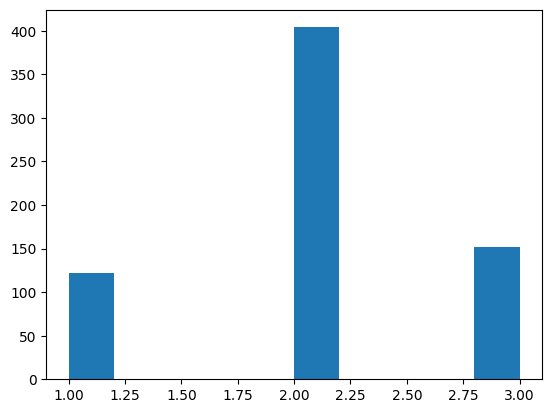

In [106]:
plt.hist(biopsy_df.stage, bins=10)

In [107]:
uqs, cs = np.unique(biopsy_df.stage, return_counts=True)
uqs, cs
# (array([1, 2, 3]), array([124, 413, 153])) before flowchart

(array([1, 2, 3]), array([122, 404, 152]))

In [108]:
(cs / cs.sum() ) * 100

array([17.99410029, 59.58702065, 22.41887906])